In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
#import pydicom
import scipy.ndimage.filters as fi
from scipy.signal import savgol_filter
import scipy.interpolate as intp
#import DynamicProgramming as DP
from mpl_toolkits import mplot3d

In [2]:
LOCAL = 20
RADIUS, SPREAD = 16, 4
RMIN, RMAX = 5, 80
MASK_SIZE = 3
mask = np.array([-1] * MASK_SIZE + [1] * MASK_SIZE) / MASK_SIZE
MAX_NODE = 3
DISPLAY = False
plt.set_cmap('gray')  # to set default colour for matplotlib to gray

<Figure size 640x480 with 0 Axes>

In [3]:
path = 'C:\\Users\\Nikitha R\\OneDrive\\Desktop\\Toshiba_test\\img\\'

file = 'US0001.png'

In [4]:
import sys      # to check if the program is running in debug mode or not
def showImage(im, title=None, numWin = None, show=True):
   # if 'pydevd' in sys.modules and DISPLAY:     # The variable pydevd is true if program is running in debug mode
        if numWin != None: plt.subplot(numWin)
        plt.imshow(im)
        plt.title(title)
        print ('hello ')
        if show:
            plt.show()
            plt.waitforbuttonpress()
            plt.close()
            return

In [5]:
def templateMatching(img, tpl):    #It uses numpy array multiplication and summation which is very fast
    ims = img.shape
    ts = tpl.shape
    ts = ts[0]//2, ts[1]//2
    corIm = np.zeros(ims, int)
    for r in range(ts[0], ims[0]-ts[0]):
        for c in range(ts[1], ims[1]-ts[1]):
            subim = img[r-ts[0]:r+ts[0]+1, c-ts[1]:c+ts[1]+1]
            corr = np.sum(subim * tpl)
            corIm[r, c] = corr
    return (corIm)

In [6]:
def plotLineHisto(line, width=None):   #Summaation of pixels in a sub-window of width X width in the image is available in corSum
    plt.plot(line), plt.show(block=False)
    plt.text(50, 50, 'width = {}'.format(width))
    plt.waitforbuttonpress()
    plt.close()

In [7]:
def deleteLocMax(img, loc):
    x, y = loc[0], loc[1]
    img[y-LOCAL:y+LOCAL, x-LOCAL:x+LOCAL] = 0

In [8]:
# it finds sum of all positive correlation values in a sub-window of increasing size till it reaches peak value
def findMaxRegion(cimg):
    h, w = cimg.shape[0:2]
    max = cimg.max()
    maxloc = np.argmax(cimg)
    RMAX = maxloc // w
    cmax = maxloc - RMAX * w
    return ((cmax, RMAX), max)

In [9]:
def showResult(img, tpl, loc):
    global DISPLAY
    tpl -= np.min(tpl)
    tpl = (tpl * 255) // np.max(tpl)
    h, w  = tpl.shape    #size of template after resizing that was found in image
    x, y = loc[0] - w//2, loc[1]-h//2 #location of template
    alpha = 0.75
    resIm = img.copy()
    for r in range(h):
        for c in range(w):
            resIm[y+r, x+c] = alpha * resIm[y+r, x+c] + (1-alpha) * tpl[r,c]

    showImage(resIm, 'template superimposed', show=True)

In [10]:
def LoGDisc(radedge, sigma=3, plot=True):
    gsize = sigma * 3
    rad = radedge + 4*sigma
    circularEdge = np.ones((2 * rad + 1, 2 * rad + 1), float)

    gaussian = np.zeros((2 * gsize + 1, 2 * gsize + 1), float)
    gaussian [ gsize, gsize] = 1
    gaussian = fi.gaussian_filter ( gaussian, sigma)
 #   if plot: showImage(gaussian, 'Gaussian', show=True)
  #  if plot: plotLineHisto(gaussian[gsize])
    LoGTpl = cv2.Laplacian(gaussian, cv2.CV_64F, ksize=3)
   # if plot: showImage(LoGTpl, 'LoG', show=True)
   # if plot: plotLineHisto(LoGTpl[gsize])

    for ri in range(-rad, rad+1):
        for ci in range(-rad, rad + 1):
            r2 =  math.sqrt(ri*ri + ci*ci)
            if r2 > radedge:
                circularEdge[ri+rad, ci+rad] = 0

    template = cv2.filter2D(circularEdge, -1, LoGTpl)
   # if plot: showImage(template, 'DoG', show=True)
   # if plot: plotLineHisto(template[rad])
    return(template)

#--------------------------------------------------------------------
def readImage(file):
    if file[-4:] == '.dcm':
        dimg = pydicom.dcmread(file)   # read the dicom image
        imgf = dimg.pixel_array     # extract the pixel data from the dicom image file
        img = np.uint8(imgf * (255 / np.max(imgf)))  # to create ndarray of bytes needed for displaying image
    else:
        img = cv2.imread(file, 0)
        img = cv2.resize(img, (256, 256))
    return (img)

In [11]:
def findMaxCorrelation(img, rho, sigma):
    cuRMAX, maxloc = 0, (0,0)
    for s in range (0, 1):
        LoGTpl = LoGDisc(rho+s, sigma)
        CorImg = templateMatching(img, LoGTpl)
        loc, max = findMaxRegion(CorImg)
        #showImage(CorImg, output, show=True)
        if max > cuRMAX:
            cuRMAX = max
            maxloc = loc
            maxs = s
            cimg = CorImg
          #  print('current max and location is for s ', max, loc, maxs)

    return(cimg, maxloc, maxs)

In [12]:
def getStrip(img, xc, yc):

    strip = np.zeros((300, RMAX - RMIN), np.uint8)

    for theta in range(300):
        th = theta * 2 * np.pi / 300
        for r in range(RMIN, RMAX):
            x = min(255, int(xc + r * np.cos(th) + 0.5))
            y = min(255, int(yc + r * np.sin(th) + 0.5))
            strip[theta, r - RMIN] = img[y, x]

    #showImage(strip,show=True)
    return (strip)

In [13]:
def verifyLoc(img, loc):
    diff = lambda v1, v2: abs(v1-v2)+1 if v1+v2 != 0 else 10

    strip = getStrip(img, loc[0], loc[1])
    #hist = cv2.calcHist([strip], [0], None, [256], [0,256])
    #plt.plot(hist), plt.show()
    thresh = 20
    strip[strip < thresh] = 0

    stripMax = np.zeros(300)
    for th in range(300):
        stripMax[th] = np.argmax(strip[th, :])+1

    score = 0
    for th in range(399):
        score += 1 / diff(stripMax[th], stripMax[th+1])

    return (score)


In [14]:
THRESHOLD = 9
inRange = lambda pi, ci, edges: True if abs(edges[pi] - edges[ci]) < THRESHOLD and edges[ci] != 0 else False

def longestRun(maxEdge):
    h, i = maxEdge.shape[0], 1
    best, st, len = 0, 0, 1
     #i=0
    while i < h:
        while i < h and inRange(st, i, maxEdge): i += 1 # find the first run without a discontinuity
        if i-st > len:
            best, len = st, i-st
        else: st = i
    avg = maxEdge[best:best+len].sum() / len
    return avg

In [42]:
def removeOutliers(maxEdge):
    # replace edge points that are missing by interpolating with next valid edge point and previous point

    h, i = maxEdge.shape[0], 1
    avg = longestRun(maxEdge)
    maxEdge[0], maxEdge[h-1] = avg, avg # the first and last edge indexes are set to average of longest run
    # so that discontinuity is checked with respect to that
    #i=0
    while i < h - 1:
        while i < h and inRange(i-1, i, maxEdge): i += 1 # find the first row where there is a discontinuity

        j = i + 1
        while j < h and inRange(i-1,j,maxEdge) == False: j += 1
        # find the next edge pixel that will be used for interpolation (pixel i to j-1)
        # rows in the range i to j have no edges (maxEdge = 0) so they should be interpolated
        for k in range(i, j-1):
            maxEdge[k] = maxEdge[i - 1] + (maxEdge[j] - maxEdge[i - 1]) * (k - i + 1) // (j - i + 1)

        i = j + 1  # Edge pixel upto j checked and interpolated. The net edge pixel to be checked for interpolation
    return

In [43]:
def adjustBoundary(strip, maxIDs):
    #Finds edges where there is a discontinuity wrt previous edge and replaces with best edge in the neighbourhood
    h, w = strip.shape[:2]
    for j in range(1, h):
        pidx, nidx = maxIDs[j-1], maxIDs[j] # index of current and previous edge
        if abs(nidx-pidx) > 3:  # There is a gap that needs to be filled with best edge nearest to it
            max, idx = 0, nidx
            for i in range(pidx-2, pidx+3):
                if i >= w-MASK_SIZE or i < MASK_SIZE: continue
                corr = np.sum(strip[j,i-MASK_SIZE:i+MASK_SIZE] * mask)
                if corr-(nidx-i)**2 > max: max, idx = corr, i
            maxIDs[j] = idx
    return

In [44]:
OVERLAP = 10

def smoothBoundary(pts):
    h = pts.shape[0]
    extEdges = np.zeros((h+2*OVERLAP), int)
    extEdges[OVERLAP:h+OVERLAP] = pts
    extEdges[0:OVERLAP] = pts[h-OVERLAP:]    # reversing the last OVERLAP items
    extEdges[h+OVERLAP:] = pts[0:OVERLAP]

    smooth_intpts = np.array(savgol_filter(extEdges,101,3), int)
    return(smooth_intpts[OVERLAP:h+OVERLAP])

In [45]:
def show3dImage():
  
  global DISPLAY

  rho, sigma = RADIUS, SPREAD
  fig = plt.figure()
  ax = plt.axes(projection="3d")
  for i in range(1,11):
    
    nm=str(i)
    name=path+'US000'+nm+'.png'
    print(name)
    img = readImage(path+'US000'+nm+'.png')
   
    cimg, loc, maxs = findMaxCorrelation(img, rho, sigma)
    #print ('max location is: ', maxloc)
  
    BPts= getBoundary(img,loc)
       
    x=[]
    y=[]
    
    for t in range(300):
        th = t * 2 * np.pi / 300
        xp = int(loc[0] + (BPts[t] + RMIN) * np.cos(th) + 0.5)
        yp = int(loc[1] + (BPts[t] + RMIN) * np.sin(th) + 0.5)
        x.append(xp)
        y.append(yp)

    
    ax.scatter3D(x,y,i,c='r',cmap='rainbow')
  plt.show()     

In [46]:
def getEdgeMap(strip): # applying edge detector
    levels, nodes = strip.shape[:2]
    corim = np.zeros((levels, nodes), int)
    corim[:,0] = 1  # The first col on each row is set to 1 so that if there are no edges on a row then also there
    # will be one non-zero pixel

    for lvl in range(levels):
        for nd in range(MASK_SIZE, nodes-MASK_SIZE):
            corim[lvl, nd] = int(np.sum(strip[lvl, nd-MASK_SIZE:nd+MASK_SIZE] * mask))
    return (corim)

In [47]:
def getBoundary(im, loc):
    strip = getStrip(im, loc[0], loc[1])
    edgeIm = getEdgeMap(strip)
    h, w = edgeIm.shape
    maxEdge = np.argmax(edgeIm, axis=1)
    i = 1  # The first edge (i = 0) is considered to be a valid one (as it is set to average value)

    #if 0:
    #    stNode, endNode = 15, 20
    #    stl, endl = 25, 100
    #    DP.findBestPath(edgeIm[stl:endl, stNode:endNode], levels=endl-stl, batch_size=6)
    #    return

    #--------------code below is bypassed for checking findbestpath

    
    #plt.subplot(311), plt.imshow(np.transpose(edgeIm)), plt.plot(maxEdge)
    removeOutliers(maxEdge)
    #plt.subplot(312), plt.imshow(np.transpose(edgeIm)), plt.plot(maxEdge)
    adjustBoundary(strip, maxEdge)
    #plt.subplot(313), plt.imshow(np.transpose(edgeIm)), plt.plot(maxEdge), plt.show()
    smoothBPts = smoothBoundary(maxEdge)
    #plt.figure(1)
    #plt.imshow(np.transpose(edgeIm))
    #plt.plot(smoothBPts), plt.show(block=True)

    return(smoothBPts)

In [48]:
def showBoundary(img, BPts, loc):
    carotidPts = []
    for t in range(300):
        th = t * 2 * np.pi / 300
        x = int(loc[0] + (BPts[t] + RMIN) * np.cos(th) + 0.5)
        y = int(loc[1] + (BPts[t] + RMIN) * np.sin(th) + 0.5)
        carotidPts.append((x, y))

    carotidPts = np.array(carotidPts)
    plt.figure(1)
    plt.imshow(img, cmap='gray'), plt.title('Image with boundary detected')
    plt.plot(carotidPts[:, 0], carotidPts[:, 1], 'r-', linewidth=2)
    plt.show(block=True)
    return

In [49]:
def main():
  
  show3dImage()

C:\Users\Nikitha R\OneDrive\Desktop\Toshiba_test\img\US0001.png


C:\Users\Nikitha R\AppData\Local\Temp\ipykernel_24760\3151077714.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  gaussian = fi.gaussian_filter ( gaussian, sigma)
C:\Users\Nikitha R\AppData\Local\Temp\ipykernel_24760\773653623.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(x,y,i,c='r',cmap='rainbow')


C:\Users\Nikitha R\OneDrive\Desktop\Toshiba_test\img\US0002.png
C:\Users\Nikitha R\OneDrive\Desktop\Toshiba_test\img\US0003.png
C:\Users\Nikitha R\OneDrive\Desktop\Toshiba_test\img\US0004.png


IndexError: index 300 is out of bounds for axis 0 with size 300

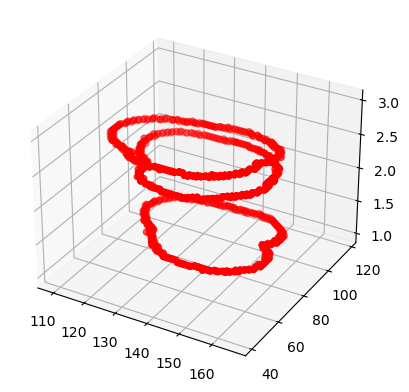

In [50]:
main()